In [2]:
import numpy as np
import pandas as pd
from scipy.stats import norm
from statsmodels.tsa.arima.model import ARIMA
import matplotlib.pyplot as plt
from scipy.optimize import minimize
from patsy import dmatrix

np.random.seed(123)

# generate a random walks with various size, sd and basis approximations
iterations = 10000
sds = np.random.uniform(0, 10, iterations)
n = np.ceil(np.random.uniform(4, 1000, iterations)).astype(int)
basis = np.ceil(np.random.uniform(4, n, iterations)).astype(int)

df = pd.DataFrame({'sds': sds, 'n': n, 'basis': basis})
df['rw_likelihood'] = np.nan
df['ap_likelihood'] = np.nan
df['diff'] = np.nan

# Filter rows where the basis is larger than the df
df = df.loc[df['basis'] < (df['n'] - 10)]

In [4]:
# Define a random walk function
def random_walk(n, sd):
    x = np.arange(1, n+1)
    y = np.zeros(n)
    for i in range(1, n):
        m = norm.rvs(loc=0, scale=sd, size=1)[0]
        l = norm.logpdf(m, loc=0, scale=sd)
        
        y[i] = y[i-1] + m
    
    return y



In [ ]:
for j in range(df.shape[0]):
    print(j+1)
    sd = df.loc[j, 'sds']
    n = df.loc[j, 'n']
    basis = df.loc[j, 'basis']
  
    y = random_walk(n, sd)
    x = np.arange(1, n+1)
  
    # Find approximation
    k = len(y)/basis
    k_positions = np.unique(np.round(np.arange(1, basis+1)*k))

    # Fit a b-spline regression
    x_bsp = dmatrix("bs(x, knots=k_positions) - 1", {"x": x})

    # Fit
    #...
    # Predict using the regression
    #y_pred = 

    mod = ARIMA(y_pred, order=(0,1,0))
    # Fit an ARIMA model to the approximation
    y_mod = mod.fit()

    # Get the ll
    df.loc[j, 'ap_likelihood'] = -1*y_mod.llf
    df.loc[j, 'rw_likelihood'] = -1*ARIMA(y, order=(0,1,0)).fit().llf
    df.loc[j, 'diff'] = df.loc[j, 'rw_likelihood'] - df.loc[j, 'ap_likelihood']
  

df = df.dropna()
df['diff_per_obs'] = df['diff'] / df['n']
df['basis_per_n'] = df['basis'] / df['n']
df['diff_log'] = np.log(df['diff_per_obs'] + 0.1)

In [ ]:

def fit(params, predict=False, basis=0.6):
    k, k2, k3, k4, C = params
    y_fit = np.exp(-k*(df['basis_per_n']**3) + k2*(df['basis_per_n']**2) + k3*df['basis_per_n'] + k4) * np.exp(C)
    y_fit = y_fit / (1.0)
    
    if predict:
        y_fit = np.exp(-k*(basis**3) + k2*(basis**2) + k3*basis + k4) * np.exp(C)
        y_fit = y_fit / (1.0)
        return y_fit
    
    res = np.mean((y_fit - df['diff_per_obs'])**2)
    return res



In [ ]:
y_fit = minimize(fit, x0=np.array([2, 0.1, 0, 0, 0]), method='Nelder-Mead').x
adj = fit(y_fit, predict=True, basis=0.06)

plt.scatter(df['basis_per_n'], df['diff_per_obs'], c=df['n'], cmap='Blues', alpha=0.5)
plt.plot(df['basis_per_n'], adj, color='red')
plt.xlabel('Basis size / n')
plt.ylabel('Difference in log-likelihood per observation')
plt.show()

### Test a simple Mathematical Solution

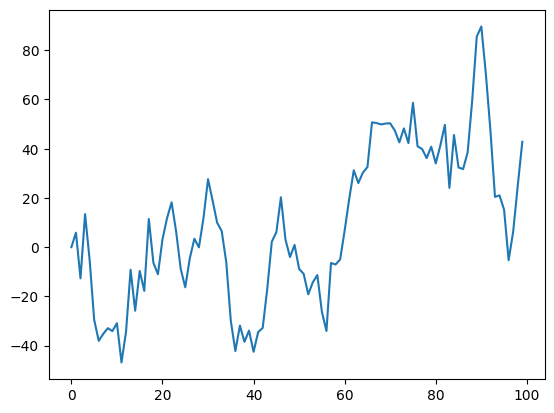

In [295]:
# Generate a simple random walk with sd = 1
n = 100
W = random_walk(n, 1)
plt.plot(W)

In [296]:
# Find the total likelihood for this walk

import os
from src.support import log_likelihood



In [297]:
L_w = log_likelihood(np.diff(W), 0, 1)

In [298]:
# Establish the equation for a Piecewise Linear Spline
def piecewise_linear(x :np.array, k :int):
    ''' Linear spline is 0 for all x < k
        and Bx for all x >= k
     For the basis - set B = 1 and let the model learn the parameter'''
    y = x - k
    y = np.where(x < 0, 0, y)
    y[[x < k for x in x]] = 0
    return y

def create_basis(x, k):
    ''' Create a linear spline basis'''
    b = np.empty((len(x), len(k)))
    for i in range(0,len(k)):
        b_i = piecewise_linear(x, k[i])
        b[:,i] = b_i
    return b


    

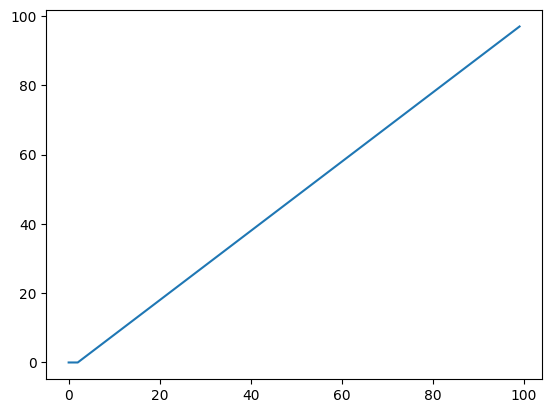

In [299]:
t = np.arange(0, len(W))
# Create a single piecewise spline and plot the result
y1 = piecewise_linear(t, k=2)
plt.plot(y1)

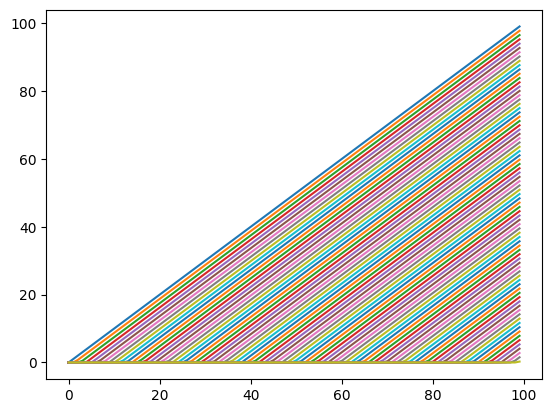

In [300]:
# Create a linear basis array with a knot at 0 and a knot at 5
k = np.linspace(0,len(x), num=80)
k = k[:-1]
b = create_basis(t, k = k)
plt.plot(b)

In [301]:
def func(betas, b, W):
        # Define the function to be optimized
        y_p = np.dot(b, betas)
        res = np.sum((y_p-W) ** 2)
        return res
    

betas = np.ones((len(k),1))   
# Optimize the function using minimize
result = minimize(func, betas, method='L-BFGS-B', args=(b, W))


/var/folders/cp/2vygt6wd1zq2dl9rjnzq0zxc0000gn/T/ipykernel_67815/4138252720.py:10: DeprecationWarning: Use of `minimize` with `x0.ndim != 1` is deprecated. Currently, singleton dimensions will be removed from `x0`, but an error will be raised in SciPy 1.11.0.
  result = minimize(func, betas, method='L-BFGS-B', args=(b, W))


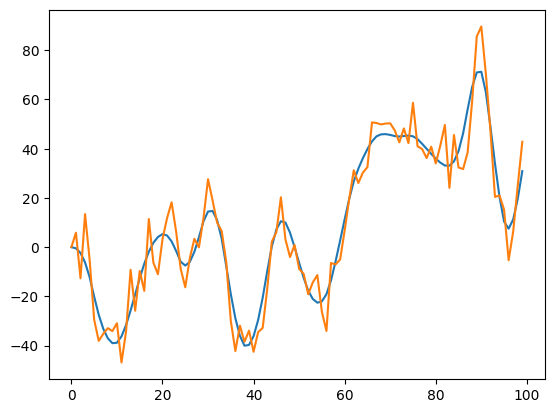

In [302]:
y_p = np.dot(b, result['x'])
plt.plot(y_p)
plt.plot(W)
plt.show()

 final_simplex: (array([[21.05866699],
       [21.05863037]]), array([4.36263563e-05, 1.15153230e-04]))
           fun: 4.3626356330150884e-05
       message: 'Optimization terminated successfully.'
          nfev: 42
           nit: 21
        status: 0
       success: True
             x: array([21.05866699])


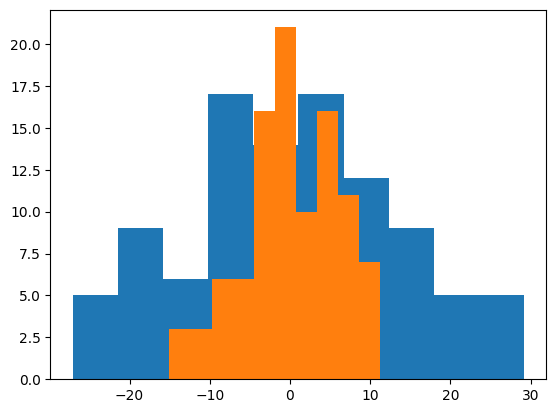

In [305]:
def L_equivalence(sd, y_p, W):
        L_w = log_likelihood(np.diff(W), 0, 1)
        L_y = log_likelihood(np.diff(y_p), 0, sd)
        res = np.abs((L_w - L_y))
        return res

def L_diff(y_p, W):
        L_w = log_likelihood(np.diff(W), 0, 1)
        L_y = log_likelihood(np.diff(y_p), 0, sd)
        res = np.abs((L_w - L_y))
        return res

plt.hist(np.diff(W))
plt.hist(np.diff(y_p))


min_sd = minimize(L_equivalence, 1, method='Nelder-Mead', args=(y_p, W))
print(min_sd)



In [306]:
print(log_likelihood(np.diff(y_p), 0, min_sd['x']))
print(log_likelihood(np.diff(W), 0, 1))

print(min_sd['x'])



-396.50639102981535
-8662.67201214181
[21.05866699]


In [284]:
L_diff(y_p, W)

-4449.026206922246